In [277]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [278]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [279]:
def build_model(transformer, loss='binary_crossentropy', max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.35)(cls_token)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=3e-5), loss=loss, metrics=[tf.keras.metrics.AUC()])
    
    return model

In [280]:
# https://stackoverflow.com/questions/8897593/how-to-compute-the-similarity-between-two-text-documents
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt') # if necessary...


stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DHIBI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [281]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.OneDeviceStrategy("GPU")  # or "GPU" if available
# No need to connect to TPU or initialize TPU system

In [282]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Save the tokenizer and its vocabulary
save_path = 'distilbert_base_uncased/'
tokenizer.save_pretrained(save_path)

print("Tokenizer and vocabulary saved successfully.")


Tokenizer and vocabulary saved successfully.


In [283]:
# First load the real tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Save the loaded tokenizer locally
save_path = '/kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [284]:
complaints=["The quality of food in the cafeteria has consistently been subpar and unsatisfactory, with tasteless and unappetizing options that fail to meet the basic expectations of employees. Despite numerous complaints and feedback, there has been no improvement in the overall food quality and variety provided.",
"Employees have repeatedly raised concerns about the lack of variety and innovation in the cafeteria menu, as it remains stagnant and offers the same limited choices day after day. The repetitive menu options fail to cater to diverse tastes and dietary preferences, resulting in dissatisfaction and disappointment among employees.",
"Hygiene and cleanliness have been major issues in the cafeteria, with frequent instances of dirty utensils, unclean food preparation areas, and unhygienic practices observed by employees. This not only compromises the overall dining experience but also poses serious health risks, including foodborne illnesses, which have been reported by some employees.",
"The exorbitant prices charged in the cafeteria are a source of frustration and financial burden for employees. Despite the high prices, the quality and variety of food remain inadequate, making it difficult for employees to justify the hefty expenses incurred for meals during work hours.",
"The seating area in the cafeteria is consistently overcrowded and uncomfortable, with limited space and insufficient seating arrangements for the growing number of employees. This not only creates a stressful dining experience but also hampers social interactions and employee well-being during lunch breaks.",
"The service in the cafeteria has been consistently slow, inefficient, and lacking in customer focus. Employees often have to endure long wait times, especially during peak hours, which significantly disrupts their work schedules and productivity.",
"The cafeteria fails to prioritize healthy and nutritious food options, with a major focus on greasy, fried, and unhealthy choices. This lack of consideration for employee well-being and dietary preferences contributes to an unhealthy work environment and undermines efforts to promote a healthy work-life balance.",
"Employees with specific dietary restrictions, such as vegetarians or vegans, face significant challenges in finding suitable options in the cafeteria. The lack of dedicated food stations or clearly labeled choices for different dietary needs further exacerbates the issue, leading to frustration and dissatisfaction among employees.",
"The cafeteria's failure to provide accurate and comprehensive allergen labeling poses serious risks to individuals with food allergies. Employees with allergies face a constant threat to their health and safety, as the absence of proper labeling increases the likelihood of accidental consumption of allergens.",
"Parking remains a persistent issue in the company, with an inadequate number of parking spaces available for employees. The scarcity of parking spots often forces employees to spend a considerable amount of time searching for parking, leading to delays in reaching their workstations and increased stress levels.",
"The parking lot's lack of proper maintenance and neglect has resulted in deteriorating conditions, with potholes, uneven surfaces, and insufficient lighting. This not only damages employees' vehicles but also poses safety hazards, especially during early mornings and late evenings when visibility is reduced.",
"Employees express frustration over the high parking fees imposed by the company, which they perceive as excessive and unfair. The financial burden of these fees adds additional strain to employees' budgets and further contributes to their dissatisfaction with the company's parking policies.",
"Inadequate parking lot lighting poses significant safety concerns for employees, particularly during darker hours. The poorly lit parking areas create an unsafe environment, making employees feel vulnerable to theft or accidents while walking to and from their vehicles.",
"The company's parking lot security measures are insufficient, leading to instances of vehicle theft and vandalism. Employees have reported incidents of break-ins and damage to their vehicles, which raises concerns about their safety and security while parked on company premises.",
"The distance between the parking lot and the office building is a major inconvenience for employees, as it adds significant travel time and effort to their daily routine. This long commute between the parking area and the workplace negatively impacts punctuality and overall employee satisfaction.",
"Work relationships within the company are strained due to a lack of team-building activities or social events. The absence of such initiatives hinders the development of stronger bonds and camaraderie among employees, ultimately impacting collaboration and teamwork in the workplace.",
"The workplace culture has been described as toxic, with instances of favoritism, gossip, and a lack of respect among colleagues. This detrimental work environment erodes employee morale, leads to conflicts, and adversely affects overall job satisfaction.",
"Bullying or harassment incidents have been reported within the company, with management failing to take appropriate measures to address and resolve such cases. The lack of prompt action creates a hostile work environment, leading to distress and a sense of insecurity among employees.",
"Employees feel limited in their professional growth and skill enhancement due to the company's limited opportunities for training and development. The lack of investment in employees' learning and advancement hinders career progression and creates a sense of stagnation.",
"The absence of mentoring or coaching programs leaves employees without proper guidance and support for their professional growth. The lack of experienced mentors to provide advice and nurture talent hampers employee development and inhibits their potential.",
"Cross-functional or cross-departmental training is not prioritized by the company, leading to a siloed work environment and hindering collaboration and knowledge sharing. The absence of opportunities to learn from colleagues in different roles or departments limits employees' exposure and growth potential.",
"The company's work-from-home policy lacks clarity and consistency in its implementation, causing confusion and frustration among employees. The absence of clear guidelines and expectations for remote work arrangements makes it challenging for employees to balance work and personal commitments effectively.",
"Employees report being consistently expected to work long hours and weekends without proper compensation or recognition for their extra efforts. The company's lack of acknowledgment for employees' dedication and commitment to their work contributes to increased stress levels and work-life imbalance.",
"The company's rigid work schedule and lack of flexibility make it challenging for employees to balance personal commitments and work responsibilities. The absence of flexible working hours or remote work options limits employees' ability to manage their personal and professional lives effectively.",
"The management team's lack of clear direction and frequent changes in priorities create confusion and inefficiency among employees. The absence of consistent leadership and strategic decision-making undermines employee morale and hampers their ability to perform effectively.",
"Managers within the company often exhibit a tendency to micromanage employees, failing to delegate tasks effectively and stifling employee autonomy. This excessive control and lack of trust in employees' abilities negatively impact job satisfaction and hinder creativity and innovation.",
"Employees feel undervalued and unappreciated due to the lack of recognition and acknowledgement for their hard work and accomplishments. The absence of a culture that celebrates employee contributions diminishes morale and diminishes motivation.",
"The company provides outdated technology and equipment that hinders employee productivity and efficiency. Employees struggle to perform their duties effectively due to slow and unreliable systems that impede their workflow and increase frustration.",
"Hardware and software provided by the company are often unreliable, frequently crashing or malfunctioning. This disrupts employees' work, resulting in wasted time and decreased productivity.",
"Employees experience ongoing technical difficulties due to the outdated and inadequate technology provided by the company. These persistent issues create frustration and hinder employees' ability to perform their tasks efficiently.",
"The company fails to prioritize the regular updating and upgrading of technology, leaving employees with outdated tools and software that hinder their performance and productivity.",
"Employees frequently encounter difficulties due to the company's failure to provide necessary materials and resources to perform their job duties effectively. The lack of essentia supplies and equipment negatively impacts employee efficiency and job satisfaction.",
"The cafeteria in the company consistently serves subpar food that lacks taste and nutritional value. Employees are dissatisfied with the quality of meals provided, which affects their overall well-being and energy levels during work hours.",
"The hygiene standards in the cafeteria are below expectations, with reports of unclean tables, dirty utensils, and unattended spills. The lack of cleanliness creates an unsanitary environment that raises concerns about food safety and employee health.",
"The parking facilities provided by the company are insufficient to accommodate the number of employees, leading to frequent parking shortages and limited availability of parking spaces. Employees struggle to find parking spots, resulting in frustration and delays in their daily commute.",
"The parking areas lack proper lighting and security measures, leaving employees feeling unsafe when arriving or leaving the premises during early mornings or late evenings. The absence of adequate lighting and security jeopardizes employee well-being and raises security concerns.",
"Employees frequently encounter issues with malfunctioning parking gates or ticketing systems, causing delays and inconvenience during entry or exit from the parking lot. The faulty systems contribute to traffic congestion and frustration among employees.",
"The company's parking policy lacks clarity and consistency, with ambiguous guidelines regarding parking permits, designated areas, and visitor parking. The lack of clear instructions adds confusion and frustration for employees trying to comply with parking regulations.",
"Employees often face difficulties in finding suitable parking spaces for individuals with disabilities. The lack of accessible parking spots or designated areas poses challenges for employees with mobility issues and goes against inclusivity principles.",
"The relationship between employees and management is strained due to a lack of open communication channels. Employees feel unheard and unvalued, as their feedback and suggestions are not given proper consideration. This communication gap affects morale and engagement within the company.",
"The company's decision-making process is opaque and lacks transparency, leading to feelings of distrust among employees. Decisions are made without clear justification or explanation, leaving employees feeling excluded from important discussions and disempowered.",
"Employees feel undervalued and unappreciated, as the company fails to recognize their efforts and provide opportunities for growth and advancement. The lack of career development prospects and reward systems impacts employee motivation and loyalty.",
"Workload distribution within the company is highly imbalanced, with some employees consistently burdened with excessive workloads while others have lighter responsibilities. The inequitable distribution leads to stress, burnout, and decreased productivity among overburdened employees.",
"The company lacks proper systems for workload prioritization and task allocation, resulting in duplicated efforts and delays. Employees struggle to manage their tasks efficiently, leading to decreased efficiency and frustration.",
"The company's performance evaluation process is flawed, with infrequent feedback and lack of constructive guidance for professional growth. Employees feel disoriented and uncertain about their progress and are unable to align their goals with organizational expectations.",
"The training programs provided by the company are insufficient to meet employees' skill development needs. There is a lack of comprehensive training initiatives that cater to various job roles and industry advancements, hindering employees' professional growth.",
"The company overlooks the importance of mentorship and coaching programs, leaving employees without guidance and support for their career development. The absence of mentorship opportunities limits employees' potential and hampers their long-term success.",
"The company fails to promote cross-functional collaboration and knowledge sharing among employees. Siloed departments and limited opportunities for cross-training lead to inefficiencies, missed opportunities, and hindered innovation.",
"The company's work-from-home policy lacks flexibility and fails to accommodate employees' individual needs. There is a lack of understanding and consideration for employees' work-life balance, resulting in increased stress and reduced job satisfaction.",
"Employees are consistently expected to work long hours, including weekends, without adequate compensation or recognition. The company's lack of appreciation for employees' dedication and work-life balance negatively impacts morale and employee well-being.",
"The company's technology infrastructure is outdated and hampers employee productivity. Slow and malfunctioning systems, obsolete software, and insufficient hardware resources contribute to frustration and hinder workflow efficiency.",
"The company's equipment and materials are outdated, unreliable, and in need of repair or replacement. Employees struggle with faulty computers, printers, and other essential tools, impacting their ability to perform their tasks efficiently.",
"The company's procurement process for technology and materials is inefficient and slow, resulting in delayed access to necessary resources. Employees face unnecessary obstacles and delays in acquiring the tools and materials needed for their work."
"The cafeteria in the company consistently serves tasteless and poorly prepared meals that leave employees unsatisfied and hungry. The lack of flavor and culinary creativity in the food offerings dampens employee morale and enjoyment during meal times.",
"The hygiene standards in the cafeteria are severely lacking, with reports of unclean food preparation areas, dirty serving utensils, and unhygienic food handling practices. Employees are concerned about the risk of foodborne illnesses and the overall cleanliness of the cafeteria environment.",
"The parking situation in the company is chaotic and disorganized, with frequent instances of unauthorized vehicles occupying designated parking spots. Employees struggle to find available parking spaces, leading to frustration and delays in starting their workday.",
"The parking lots lack proper maintenance, with potholes, inadequate lighting, and unclear signage. Employees have to navigate through poorly maintained areas, increasing the risk of accidents and damage to their vehicles.",
"The company's parking policy is overly restrictive and inflexible, with limited options for alternative transportation or carpooling. Employees feel burdened by strict regulations and the lack of consideration for their commuting needs.",
"Employees often encounter broken or malfunctioning hardware and equipment in their workstations. The lack of timely repairs or replacements hinders productivity and creates frustration as employees are unable to perform their tasks effectively.",
"The company's technology infrastructure is outdated and incompatible with modern software and applications. This results in frequent system crashes, compatibility issues, and limitations in accessing essential tools and resources.",
"The company fails to provide adequate training and support for employees to effectively utilize new technologies and tools. Employees struggle with the learning curve and are unable to fully leverage the available technology, impacting their efficiency and performance.",
"Employees feel overwhelmed and overburdened with excessive workloads, unrealistic deadlines, and constant multitasking. The lack of resource allocation and work prioritization leads to stress, decreased productivity, and a negative impact on work-life balance.",
"Communication within the company is ineffective and fragmented, with a lack of clear and timely information flow. Employees are left uninformed about important updates, changes, and decisions, leading to confusion and misunderstandings.",
"The company's leadership is disconnected from the needs and concerns of the employees. There is a lack of open-door policy and transparent communication, leaving employees feeling unheard and undervalued.",
"Managers in the company lack the necessary leadership and people management skills to motivate and inspire their teams. Employees feel demotivated and unengaged, leading to decreased morale and subpar performance.",
"The company lacks a comprehensive employee recognition and reward system. Employees' hard work and achievements go unnoticed, leading to a lack of motivation and a sense of underappreciation.",
"The company's onboarding and orientation process for new employees is inadequate. New hires feel overwhelmed and ill-prepared to navigate their roles and responsibilities, hindering their integration into the company.",
"The company disregards employee well-being and fails to provide adequate support for work-life balance. Employees struggle to manage personal commitments and work responsibilities, leading to increased stress and burnout.",
"Employees face discriminatory practices and biases within the company, resulting in unequal treatment and limited opportunities for certain individuals or marginalized groups. The lack of inclusivity and diversity negatively impacts employee morale and organizational culture.",
"The company's performance evaluation process lacks transparency and fairness. Employees perceive favoritism and biased assessments, leading to demotivation and a lack of trust in the performance management system.",
"Employees feel the company lacks a clear career development path, with limited opportunities for growth and advancement. The absence of clear progression guidelines leaves employees feeling stagnant and unfulfilled in their roles.",
"The company's training programs are outdated and fail to address the evolving needs and skills required for employees' professional development. Employees lack access to relevant and up-to-date training opportunities.",
"The company's work environment is riddled with office politics, cliques, and favoritism. Employees feel alienated and excluded, which negatively impacts teamwork and collaboration.",
"The company's HR department lacks responsiveness and fails to address employee concerns and grievances in a timely and satisfactory manner. Employees feel unsupported and discouraged from voicing their concerns.",
"Employees experience inadequate compensation and benefits packages compared to industry standards. The lack of competitive pay and limited benefits affect employee satisfaction and retention rates.",
"The company's policies regarding work-life balance are inflexible and fail to accommodate employees' personal needs and responsibilities. The absence of remote work options and flexible schedules hinders employees' ability to achieve a healthy work-life balance.",
"Employees face a lack of transparency in decision-making processes and company policies. The absence of open communication channels and involvement in decision-making leaves employees feeling disconnected and uninformed."
"The cafeteria consistently serves uninspiring and monotonous meals, lacking variety and creativity. Employees are bored with the limited menu options and crave more exciting and diverse food choices.",
"Hygiene issues in the cafeteria persist, with reports of unclean tables, sticky floors, and unwashed utensils. Employees are concerned about the risk of food contamination and the overall cleanliness of the dining area.",
"The parking situation in the company is chaotic and frustrating, with limited parking spaces that are always occupied. Employees spend valuable time circling the parking lot, searching for an available spot.",
"The company fails to provide sufficient parking spaces for employees, forcing them to park in unauthorized areas or far away from the workplace. This leads to inconvenience and safety concerns during the commute.",
"The company's hardware and equipment are outdated and prone to frequent breakdowns. Employees often encounter malfunctioning computers, printers, and other essential tools, causing delays and hindering productivity.",
"The technology infrastructure in the company is unreliable and slow, resulting in constant disruptions and delays in accessing necessary software and systems. Employees struggle with system crashes and network outages.",
"Employees frequently face work overload, with unrealistic deadlines and an excessive number of tasks to complete. The unmanageable workload leads to stress, burnout, and a decline in the quality of work.",
"Communication gaps and miscommunication within teams and across departments are common, causing delays, misunderstandings, and errors. Employees struggle to collaborate effectively and share information efficiently.",
"Managers in the company lack the necessary leadership skills to inspire and motivate their teams. Employees feel demotivated and undervalued, leading to decreased morale and job satisfaction.",
"The company's performance evaluation process lacks transparency and fairness. Employees feel that their contributions are not accurately assessed, leading to a lack of recognition and opportunities for growth.",
"There is a lack of team-building activities and events to foster stronger relationships among employees. The absence of social interactions hinders teamwork, collaboration, and a positive work environment.",
"The company's culture promotes unhealthy competition and a lack of cooperation among employees. This results in a toxic work environment, where individuals prioritize personal success over teamwork.",
"The company overlooks the importance of employee training and development, hindering career advancement and skill enhancement. Employees feel stagnant and unsupported in their professional growth.",
"Employees lack access to mentorship programs and guidance to enhance their skills and knowledge. The absence of mentorship opportunities negatively affects employee development and progression.",
"The company's work-from-home policy is unclear and inconsistently implemented. Employees struggle with the lack of guidelines and expectations, impacting their ability to work remotely effectively.",
"Employees face constant pressure to work long hours and are often expected to be available outside of regular working hours. This leads to work-life imbalance and increased stress levels.",
"The company fails to prioritize employee well-being and mental health. The lack of resources and support for mental well-being leads to increased stress, anxiety, and decreased job satisfaction.",
"Managers in the company exhibit a lack of empathy and understanding towards employees' personal challenges and difficulties. This results in a lack of support and flexibility in accommodating employees' needs.",
"The company's leadership lacks a clear vision and direction, resulting in a lack of alignment and confusion among employees. Employees struggle to understand the company's goals and objectives.",
"The company's technological tools and equipment are outdated and incompatible with industry standards. Employees face challenges in performing their tasks efficiently and keeping up with technological advancements.",
"The company's materials and supplies are of poor quality and often fail to meet the employees' needs. This leads to frustration and inefficiencies in completing tasks.",
"The company lacks proper maintenance of its facilities and infrastructure, resulting in frequent breakdowns and disruptions. Employees experience inconvenience and delays in their daily work due to facility issues.",
"The company's purchasing process for materials and equipment is slow and inefficient. Employees face delays in receiving necessary supplies, impacting their productivity and ability to meet deadlines.",
"The company's training programs are outdated and fail to address the evolving needs of employees. Employees feel that the training provided does not equip them with the necessary skills for their roles.",
"The company's onboarding process for new employees is ineffective and lacks proper guidance and support. New hires struggle to integrate into the company culture and understand their roles and responsibilities.",
"Employees lack access to cross-functional training opportunities, limiting their ability to collaborate and work effectively with colleagues from different departments.",
"The company's performance management system lacks transparency and fails to provide meaningful feedback and recognition. Employees feel undervalued and struggle to understand how their performance is evaluated.",
"The company's recognition and rewards program is inadequate and fails to motivate employees. Employees feel unappreciated and lack incentives for their hard work and contributions.",
"The company's workplace policies and procedures are outdated and do not reflect the evolving needs of employees. Employees face difficulties in navigating the bureaucratic processes and feel restricted.",
"Employees experience a lack of trust and transparency in the decision-making process. The absence of employee involvement in important decisions leads to decreased morale and engagement.",
"The company's HR department lacks responsiveness and fails to address employee concerns and grievances in a timely and satisfactory manner. Employees feel unsupported and discouraged from voicing their concerns.",
"Employees experience inadequate compensation and benefits packages compared to industry standards. The lack of competitive pay and limited benefits affect employee satisfaction and retention rates.",
"The company's policies regarding work-life balance are inflexible and fail to accommodate employees' personal needs and responsibilities. The absence of remote work options and flexible schedules hinders employees' ability to achieve a healthy work-life balance.",
"Employees face a lack of transparency in decision-making processes and company policies. The absence of open communication channels and involvement in decision-making leaves employees feeling disconnected and uninformed.",
"The cafeteria consistently serves uninspiring and monotonous meals, lacking variety and creativity. Employees are bored with the limited menu options and crave more exciting and diverse food choices.",
"Hygiene issues in the cafeteria persist, with reports of unclean tables, sticky floors, and unwashed utensils. Employees are concerned about the risk of food contamination and the overall cleanliness of the dining area.",
"The parking situation in the company is chaotic and frustrating, with limited parking spaces that are always occupied. Employees spend valuable time circling the parking lot, searching for an available spot.",
"The company fails to provide sufficient parking spaces for employees, forcing them to park in unauthorized areas or far away from the workplace. This leads to inconvenience and safety concerns during the commute.",
"The company's hardware and equipment are outdated and prone to frequent breakdowns. Employees often encounter malfunctioning computers, printers, and other essential tools, causing delays and hindering productivity.",
"The technology infrastructure in the company is unreliable and slow, resulting in constant disruptions and delays in accessing necessary software and systems. Employees struggle with system crashes and network outages.",
"Employees frequently face work overload, with unrealistic deadlines and an excessive number of tasks to complete. The unmanageable workload leads to stress, burnout, and a decline in the quality of work.",
"Communication gaps and miscommunication within teams and across departments are common, causing delays, misunderstandings, and errors. Employees struggle to collaborate effectively and share information efficiently.",
"Managers in the company lack the necessary leadership skills to inspire and motivate their teams. Employees feel demotivated and undervalued, leading to decreased morale and job satisfaction.",
"The company's performance evaluation process lacks transparency and fairness. Employees feel that their contributions are not accurately assessed, leading to a lack of recognition and opportunities for growth.",
"There is a lack of team-building activities and events to foster stronger relationships among employees. The absence of social interactions hinders teamwork, collaboration, and a positive work environment.",
"The company's culture promotes unhealthy competition and a lack of cooperation among employees. This results in a toxic work environment, where individuals prioritize personal success over teamwork.",
"The company overlooks the importance of employee training and development, hindering career advancement and skill enhancement. Employees feel stagnant and unsupported in their professional growth.",
"Employees lack access to mentorship programs and guidance to enhance their skills and knowledge. The absence of mentorship opportunities negatively affects employee development and progression.",
"The company's work-from-home policy is unclear and inconsistently implemented. Employees struggle with the lack of guidelines and expectations, impacting their ability to work remotely effectively.",
"Employees face constant pressure to work long hours and are often expected to be available outside of regular working hours. This leads to work-life imbalance and increased stress levels.",
"The company fails to prioritize employee well-being and mental health. The lack of resources and support for mental well-being leads to increased stress, anxiety, and decreased job satisfaction.",
"Managers in the company exhibit a lack of empathy and understanding towards employees' personal challenges and difficulties. This results in a lack of support and flexibility in accommodating employees' needs.",
"The company's leadership lacks a clear vision and direction, resulting in a lack of alignment and confusion among employees. Employees struggle to understand the company's goals and objectives.",
"The company's technological tools and equipment are outdated and incompatible with industry standards. Employees face challenges in performing their tasks efficiently and keeping up with technological advancements.",
"The company's materials and supplies are of poor quality and often fail to meet the employees' needs. This leads to frustration and inefficiencies in completing tasks.",
"The company lacks proper maintenance of its facilities and infrastructure, resulting in frequent breakdowns and disruptions. Employees experience inconvenience and delays in their daily work due to facility issues.",
"The company's purchasing process for materials and equipment is slow and inefficient. Employees face delays in receiving necessary supplies, impacting their productivity and ability to meet deadlines.",
"The company's IT support is unresponsive and fails to address employees' technical issues in a timely manner. Employees experience prolonged downtime and decreased productivity as a result.",
"The company's training programs lack relevance and fail to provide employees with the necessary skills and knowledge for their roles. Employees feel ill-equipped to perform their duties effectively.",
"The company's performance appraisal system is subjective and lacks transparency. Employees feel that their performance evaluations are biased, hindering their career growth and advancement.",
"The company's workplace environment is noisy and distractive, making it difficult for employees to concentrate and focus on their work. The lack of a quiet and peaceful work area affects productivity.",
"Employees experience frequent power outages and disruptions in the company's infrastructure. The unstable electrical system leads to interrupted work and data loss, impacting employee efficiency.",
"The company's furniture and seating arrangements are uncomfortable and ergonomically unsuitable. Employees suffer from back pain and discomfort due to inadequate seating options.",
"The company's network security measures are insufficient, leading to frequent data breaches and security risks. Employees are concerned about the confidentiality and integrity of their work-related information.",
"The company's project management practices are disorganized and lack structure. Employees struggle with unclear priorities, changing deadlines, and misaligned expectations, resulting in project delays.",
"The company's communication channels, such as emails and messaging systems, frequently experience technical glitches and delays in message delivery. This hinders effective communication and collaboration among employees.",
"The company's policies regarding vacation and time-off requests are restrictive and inflexible. Employees face challenges in taking time off for personal reasons or emergencies, leading to increased stress levels.",
"The company's recruitment and hiring process is inefficient and time-consuming. Employees experience delays in filling vacant positions, resulting in increased workload and stretched resources.",
"The company's travel expense reimbursement process is complicated and slow. Employees face delays in receiving reimbursements for business-related travel expenses, causing financial strain.",
"The company's decision-making processes are slow and bureaucratic. Employees experience delays in obtaining approvals and decisions, impacting their ability to execute tasks efficiently.",
"The company's customer service department lacks responsiveness and fails to address employee concerns and inquiries in a timely manner. Employees feel unsupported and frustrated with the lack of assistance.",
"The company's dress code policy is outdated and restrictive. Employees feel limited in expressing their individuality and personal style, leading to decreased morale and self-expression.",
"The company's facilities lack proper ventilation and air conditioning, resulting in uncomfortable working conditions. Employees struggle with high temperatures and poor air quality, impacting their focus and well-being.",
"Employees feel a lack of autonomy and decision-making authority in their roles. The absence of empowerment leads to decreased job satisfaction and motivation to take ownership of their work.",
"The company's supplier management process is inefficient and leads to delays in receiving necessary materials and goods. Employees face challenges in meeting deadlines and fulfilling customer orders.",
"The company's performance incentives and bonuses are not aligned with employee performance and achievements. Employees feel that their hard work and accomplishments are not adequately recognized and rewarded.",
"The company's conflict resolution processes are ineffective, resulting in unresolved conflicts among employees. The lack of mediation and resolution leads to tension and strained relationships within the workplace.",
"The company's maternity and paternity leave policies are inadequate and fail to support employees during important life transitions. Employees feel unsupported in balancing their work and family responsibilities.",
"The company's diversity and inclusion initiatives are minimal, leading to a lack of representation and inclusivity. Employees feel that their voices and perspectives are not valued or considered.",
"The company's employee benefits package is subpar compared to industry standards. Employees feel undervalued and struggle to access necessary healthcare and wellness resources.",
"The company's employee performance development plans are vague and lack clarity. Employees are unsure about their career paths and opportunities for growth within the organization.",
"The company's corporate social responsibility initiatives are insufficient. Employees feel that the company should do more to give back to the community and address social and environmental issues.",
"The company's disciplinary actions are inconsistent and lack transparency. Employees feel uncertain about the consequences of their actions and the fairness of disciplinary measures.",
"The company's office layout and design are uninspiring and lack creativity. Employees feel demotivated in an environment that does not foster creativity and innovation.",
"The company's reimbursement process for work-related expenses is slow and cumbersome. Employees face delays in receiving reimbursements, leading to financial strain and dissatisfaction.",
"The company's performance metrics and KPIs are unrealistic and unattainable. Employees feel undue pressure to meet unachievable targets, leading to stress and decreased job satisfaction.",
"The company's team dynamics are problematic, with conflicts and lack of collaboration. Employees struggle to work effectively together, impacting overall team performance and results.",
"The company's recognition and rewards program is inconsistent and lacks transparency. Employees feel that the criteria for recognition are unclear, leading to dissatisfaction and demotivation.",
"The company's annual performance review process is lengthy and bureaucratic. Employees feel that the process is time-consuming and does not provide meaningful feedback for growth and improvement.",
"The company's supply chain management is inefficient and leads to delays in receiving necessary materials. Employees face challenges in meeting production deadlines and satisfying customer demands.",
"The company's equipment maintenance and repair services are unreliable and slow. Employees experience delays in getting their equipment fixed, causing interruptions in their work.",
"The company's compliance and regulatory processes are complex and burdensome. Employees struggle to navigate the requirements, leading to potential legal risks and penalties.",
"The company's data management practices are inadequate, leading to data breaches and privacy concerns. Employees are worried about the security of their personal and work-related information.",
"The company's leadership team lacks diversity and representation. Employees feel that different perspectives and experiences are not adequately represented at the leadership level.",
"The company's facilities lack proper restroom maintenance, with dirty facilities and inadequate supplies. Employees feel discomfort and embarrassment due to the lack of hygienic restroom conditions.",
"The company's performance feedback process is infrequent and lacks specificity. Employees feel that they do not receive timely and constructive feedback to improve their performance.",
"The company's expense reimbursement policy is restrictive and fails to cover necessary expenses incurred during work-related activities. Employees face financial burden and limited resources.",
"The company's goal-setting process is unclear and lacks alignment with employee roles and responsibilities. Employees struggle to understand how their individual goals contribute to the company's objectives.",
"The company's customer complaint resolution process is inefficient and lacks responsiveness. Employees find it challenging to resolve customer issues in a timely and satisfactory manner.",
"The company's internal communication channels are ineffective, leading to information gaps and miscommunication among employees. Employees struggle to stay informed and connected with the company's updates.",
"The company's promotional opportunities are limited, leading to a lack of career growth and advancement. Employees feel stagnant in their roles and are discouraged from pursuing new opportunities.",
"The company's performance recognition is biased and inconsistent. Employees feel that favoritism plays a role in determining who receives recognition and rewards.",
"The company's training materials and resources are outdated and fail to address current industry trends. Employees feel that the training provided does not equip them with relevant skills.",
"The company's decision-making processes are hierarchical and slow, inhibiting innovation and agility. Employees feel frustrated by the lack of involvement and influence in important decisions.",
"The company's employee engagement initiatives are inadequate, resulting in low morale and reduced productivity. Employees feel disconnected and disengaged from the company's mission and goals.",
"The company's resource allocation is unfair and lacks transparency. Employees feel that resources are not distributed equitably, leading to disparities in workload and opportunities.",
"The company's performance evaluation criteria are unclear and subjective. Employees feel that their evaluations are based on subjective opinions rather than objective measures of performance.",
"The company's workspaces lack privacy and proper soundproofing. Employees struggle with distractions and noise, impacting their concentration and productivity.",
"The company's professional development opportunities are limited, leaving employees with limited avenues for skill enhancement and career growth.",
"The company's financial compensation is below industry standards, leading to dissatisfaction and increased turnover rates among employees.",
"The company's onboarding process is disorganized and fails to provide new hires with the necessary information and resources to succeed in their roles.",
"The company's project prioritization process is flawed, leading to conflicting priorities and ineffective resource allocation. Employees struggle to understand which projects to prioritize and focus on.",
"The company's facilities lack proper security measures, leading to concerns about the safety of employees and their belongings.",
"The company's code of conduct is vague and lacks clarity, leaving employees unsure of what behavior is expected of them.",
"The company's performance-based rewards are inconsistent and fail to provide meaningful incentives for employees to excel in their roles.",
"The company's feedback culture is non-existent, with a lack of open and constructive feedback among employees and managers.",
"The company's communication channels are outdated and unreliable, leading to difficulties in sharing important information and updates with employees.",
"The company's promotions and career advancement opportunities are biased and favor certain individuals, leading to a lack of equal opportunities for all employees.",
"The company's performance goals and targets are unrealistic and unattainable, causing employees to feel demotivated and overwhelmed.",
"The company's procurement process is slow and inefficient, resulting in delays in obtaining necessary materials and supplies for employees.",
"The company's decision-making processes are centralized and lack employee input, leading to a lack of ownership and commitment from employees.",
"The company's recognition and rewards program is poorly communicated, leaving employees unaware of the criteria for recognition and rewards.",
"The company's organizational structure is hierarchical and inhibits communication and collaboration across departments.",
"The company's communication strategy is one-way and lacks opportunities for employee feedback and input.",
"The company's work environment lacks diversity and inclusion, leading to a lack of perspectives and ideas.",
"The company's professional development opportunities are limited to certain job roles or departments, leaving other employees without access to growth opportunities.",
"The company's workload distribution is uneven, leading to burnout and stress for some employees while others have lighter workloads.",
"The company's promotion process lacks transparency, leading to feelings of unfairness and favoritism among employees.",
"The company's decision-making processes are slow and bureaucratic, causing delays in implementing necessary changes and improvements.",
"The company's performance management system is overly focused on individual achievements rather than team collaboration and success.",
"The company's management style is autocratic and micromanaging, stifling employee creativity and innovation.",
"The company's IT infrastructure is outdated and hinders employees' ability to work efficiently and effectively.",
"The company's business goals and objectives are unclear and poorly communicated, leaving employees unsure of the company's direction.",
"The company's employee benefits package is limited and does not adequately meet employees' needs and expectations.",
"The company's work schedules and shift rotations are inflexible, making it difficult for employees to balance work and personal obligations.",
"The company's remote work policy is restrictive and does not provide sufficient flexibility for employees to work from home or remotely.",
"The company's decision-making processes are influenced by politics and personal biases, rather than objective criteria and data.",
"The company's organizational culture is toxic, with a lack of trust, respect, and open communication among employees.",
"The company's performance metrics and targets are unrealistic and do not take into account external factors or constraints that impact employees' ability to achieve them.",
"The company's career development opportunities are limited, with few options for employees to grow and advance within the organization.",
"The company's job roles and responsibilities are poorly defined, leading to confusion and overlap in tasks among employees.",
"The company's leadership team lacks visibility and accessibility, leading to a lack of guidance and support for employees.",
"The company's decision-making processes are centralized, with limited input and involvement from employees at lower levels.",
"The company's training and development programs are outdated and fail to address the evolving needs and skills required in the industry.",
"The company's employee performance evaluation process lacks transparency and objective criteria, leading to perceived favoritism and bias.",
"The company's communication channels are fragmented and lack integration, making it difficult for employees to access important information and updates.",
"The company's disciplinary actions and policies are inconsistent and lack clear guidelines, leading to confusion and uncertainty among employees.",
"The company's employee engagement initiatives are ineffective and fail to foster a sense of belonging and motivation among employees.",
"The company's workspaces are overcrowded and lack sufficient space for employees to work comfortably and efficiently.",
"The company's travel policies are restrictive and make it challenging for employees to fulfill their job responsibilities effectively while traveling.",
"The company's IT support services are inadequate and slow to respond to employees' technical issues and needs.",
"The company's performance evaluation criteria are unclear and not aligned with employees' roles and responsibilities.",
"The company's management team lacks diversity and representation, resulting in limited perspectives and ideas in decision-making processes.",
"The company's decision-making processes are bureaucratic and slow, causing delays in implementing necessary changes and improvements.",
"The company's internal communication is top-down and lacks opportunities for employees to provide feedback and contribute ideas.",
"The company's performance-based incentives and rewards are not aligned with employees' individual goals and priorities.",
"The company's organizational structure is rigid and hierarchical, hindering collaboration and innovation among employees.",
"The company's employee recognition program is inconsistent and fails to acknowledge and appreciate employees' efforts and contributions.",
"The company's training and development opportunities are limited, leaving employees without the necessary skills and knowledge to excel in their roles.",
"The company's performance feedback is infrequent and lacks specificity, making it difficult for employees to understand areas for improvement.",
"The company's decision-making processes are opaque and lack transparency, leading to a lack of trust and buy-in from employees.",
"The company's work-life balance policies are inadequate, with employees struggling to maintain a healthy equilibrium between work and personal life.",
"The company's delegation of tasks and responsibilities is ineffective, leading to a lack of clarity and accountability among employees.",
"The company's communication culture is non-collaborative, with a lack of sharing information and knowledge among employees.",
"The company's employee recognition programs are limited to monetary rewards, neglecting the importance of non-financial recognition and appreciation.",
"The company's training programs are generic and fail to address specific skill gaps and developmental needs of employees.",
"The company's decision-making processes are decentralized and lack clear guidelines, resulting in inconsistency and confusion among employees.",
"The company's team-building activities are infrequent and fail to foster strong relationships and collaboration among employees.",
"The company's leadership style is authoritarian, with little input or involvement from employees in decision-making processes.",
"The company's employee performance evaluation process is subjective and lacks objectivity and fairness.",
"The company's resources and support for employee well-being are insufficient, leading to increased stress and burnout among employees.",
"The company's feedback mechanisms are inadequate, with employees lacking opportunities to provide input and suggest improvements.",
"The company's performance goals are unrealistic and unattainable, leading to a lack of motivation and decreased morale among employees.",
"The company's recruitment process is slow and inefficient, resulting in difficulties in attracting and hiring qualified candidates.",
"The company's team communication is ineffective, with a lack of clarity and coordination in work-related discussions and updates.",
"The company's decision-making processes are risk-averse, inhibiting innovation and creativity among employees.",
"The company's professional growth opportunities are limited to specific departments or roles, leaving other employees with limited avenues for advancement.",
"The company's performance evaluations lack constructive feedback and developmental guidance for employees to improve their skills and performance.",
"The company's work environment lacks inclusivity and diversity, leading to a lack of representation and cultural sensitivity.",
"The company's project planning and resource allocation are ineffective, resulting in frequent delays and missed deadlines.",
"The company's communication channels are overwhelmed with irrelevant information, making it challenging for employees to filter and find important messages.",
"The company's employee recognition program is inconsistent and lacks transparency in the selection and rewards process.",
"The company's decision-making processes are excessively bureaucratic and slow, hindering timely actions and responsiveness.",
"The company's performance evaluation system is heavily focused on quantitative metrics, neglecting qualitative aspects of employees' contributions.",
"The company's workload expectations are unrealistic and lead to employee burnout and decreased productivity.",
"The company's feedback culture is non-existent, with a lack of open and constructive feedback among employees and managers.",
"The company's communication channels are outdated and unreliable, leading to difficulties in sharing important information and updates with employees.",
"The company's promotions and career advancement opportunities are biased and favor certain individuals, leading to a lack of equal opportunities for all employees.",
"The company's performance goals and targets are unrealistic and unattainable, causing employees to feel demotivated and overwhelmed.",
"The company's procurement process is slow and inefficient, resulting in delays in obtaining necessary materials and supplies for employees.",
"The company's decision-making processes are influenced by politics and personal biases, rather than objective criteria and data.",
"The company's organizational culture is toxic, with a lack of trust, respect, and open communication among employees.",
"The company's performance metrics and targets are unrealistic and do not take into account external factors or constraints that impact employees' ability to achieve them.",
"The company's career development opportunities are limited, with few options for employees to grow and advance within the organization.",
"The company's job roles and responsibilities are poorly defined, leading to confusion and overlap in tasks among employees.",
"The company's leadership team lacks visibility and accessibility, leading to a lack of guidance and support for employees.",
"The company's decision-making processes are centralized, with limited input and involvement from employees at lower levels.",
"The company's training and development programs are outdated and fail to address the evolving needs and skills required in the industry.",
"The company's employee performance evaluation process lacks transparency and objective criteria, leading to perceived favoritism and bias.",
"The company's communication channels are fragmented and lack integration, making it difficult for employees to access important information and updates.",
"The company's disciplinary actions and policies are inconsistent and lack clear guidelines, leading to confusion and uncertainty among employees.",
"The company's employee engagement initiatives are ineffective and fail to foster a sense of belonging and motivation among employees.",
"The company's workspaces are overcrowded and lack sufficient space for employees to work comfortably and efficiently.",
"The company's travel policies are restrictive and make it challenging for employees to fulfill their job responsibilities effectively while traveling.",
"The company's IT support services are inadequate and slow to respond to employees' technical issues and needs.",
"The company's performance evaluation criteria are unclear and not aligned with employees' roles and responsibilities.",
"The company's management team lacks diversity and representation, resulting in limited perspectives and ideas in decision-making processes.",
"The company's decision-making processes are bureaucratic and slow, causing delays in implementing necessary changes and improvements.",
"The company's internal communication is top-down and lacks opportunities for employees to provide feedback and contribute ideas.",
"The company's performance-based incentives and rewards are not aligned with employees' individual goals and priorities.",
"The company's organizational structure is rigid and hierarchical, hindering collaboration and innovation among employees.",
"The company's employee recognition program is inconsistent and fails to acknowledge and appreciate employees' efforts and contributions.",
"The company's training and development opportunities are limited, leaving employees without the necessary skills and knowledge to excel in their roles.",
"The company's performance feedback is infrequent and lacks specificity, making it difficult for employees to understand areas for improvement.",
"The company's decision-making processes are opaque and lack transparency, leading to a lack of trust and employee dissatisfaction.",
"The company's work-life balance policies are inadequate, with employees struggling to maintain a healthy equilibrium between work and personal life.",
"The company's delegation of tasks and responsibilities is ineffective, leading to a lack of clarity and accountability among employees.",
"The company's communication culture is non-collaborative, with a lack of sharing information and knowledge among employees.",
"The company's employee recognition programs are limited to monetary rewards, neglecting the importance of non-financial recognition and appreciation.",
"The company's training programs are generic and fail to address specific skill gaps and developmental needs of employees.",
"The company's decision-making processes are decentralized and lack clear guidelines, resulting in inconsistency and confusion among employees.",
"The company's team-building activities are infrequent and fail to foster strong relationships and collaboration among employees.",
"The company's leadership style is authoritarian, with little input or involvement from employees in decision-making processes.",
"The company's employee performance evaluation process is subjective and lacks objectivity and fairness.",
"The company's resources and support for employee well-being are insufficient, leading to increased stress and burnout among employees.",
"The company's feedback mechanisms are inadequate, with employees lacking opportunities to provide input and suggest improvements.",
"The company's performance goals are unrealistic and unattainable, leading to a lack of motivation and decreased morale among employees.",
"The company's recruitment process is slow and inefficient, resulting in difficulties in attracting and hiring qualified candidates.",
"The company's team communication is ineffective, with a lack of clarity and coordination in work-related discussions and updates.",
"The company's decision-making processes are risk-averse, inhibiting innovation and creativity among employees.",
"The company's professional growth opportunities are limited to specific departments or roles, leaving other employees with limited avenues for advancement.",
"The company's performance evaluations lack constructive feedback and developmental guidance for employees to improve their skills and performance.",
"The company's work environment lacks inclusivity and diversity, leading to a lack of representation and cultural sensitivity.",
"The company's project planning and resource allocation are ineffective, resulting in frequent delays and missed deadlines.",
"The company's communication channels are overwhelmed with irrelevant information, making it challenging for employees to filter and find important messages.",
"The company's employee recognition program is inconsistent and lacks transparency in the selection and rewards process.",
"The company's decision-making processes are excessively bureaucratic and slow, hindering timely actions and responsiveness.",
"The company's performance evaluation system is heavily focused on quantitative metrics, neglecting qualitative aspects of employees' contributions.",
"The company's workload expectations are unrealistic and lead to employee burnout and decreased productivity.",
"The company's feedback culture is non-existent, with a lack of open and constructive feedback among employees and managers.",
"The company's communication channels are outdated and unreliable, leading to difficulties in sharing important information and updates with employees.",
"The company's promotions and career advancement opportunities are biased and favor certain individuals, leading to a lack of equal opportunities for all employees.",
"The company's performance goals and targets are unrealistic and unattainable, causing employees to feel demotivated and overwhelmed.",
"The company's procurement process is slow and inefficient, resulting in delays in obtaining necessary materials and supplies for employees.",
"The company's decision-making processes are influenced by politics and personal biases, rather than objective criteria and data.",
"The company's organizational culture is toxic, with a lack of trust, respect, and open communication among employees.",
"The company's performance metrics and targets are unrealistic and do not take into account external factors or constraints that impact employees' ability to achieve them.",
"The company's career development opportunities are limited, with few options for employees to grow and advance within the organization.",
"The company's job roles and responsibilities are poorly defined, leading to confusion and overlap in tasks among employees.",
"The company's leadership team lacks visibility and accessibility, leading to a lack of guidance and support for employees.",
"The company's decision-making processes are centralized, with limited input and involvement from employees at lower levels.",
"The company's training and development programs are outdated and fail to address the evolving needs and skills required in the industry.",
"The company's employee performance evaluation process lacks transparency and objective criteria, leading to perceived favoritism and bias.",
"The company's communication channels are fragmented and lack integration, making it difficult for employees to access important information and updates.",
"The company's disciplinary actions and policies are inconsistent and lack clear guidelines, leading to confusion and uncertainty among employees.",
"The company's employee engagement initiatives are ineffective and fail to foster a sense of belonging and motivation among employees.",
"The company's workspaces are overcrowded and lack sufficient space for employees to work comfortably and efficiently.",
"The company's travel policies are restrictive and make it challenging for employees to fulfill their job responsibilities effectively while traveling.",
"The company's IT support services are inadequate and slow to respond to employees' technical issues and needs.",
"The company's performance evaluation criteria are unclear and not aligned with employees' roles and responsibilities.",
"The company's management team lacks diversity and representation, resulting in limited perspectives and ideas in decision-making processes.",
"The company's decision-making processes are bureaucratic and slow, causing delays in implementing necessary changes and improvements.",
"The company's internal communication is top-down and lacks opportunities for employees to provide feedback and contribute ideas.",
"The company's performance-based incentives and rewards are not aligned with employees' individual goals and priorities.",
"The company's organizational structure is rigid and hierarchical, hindering collaboration and innovation among employees.",
"The company's employee recognition program is inconsistent and fails to acknowledge and appreciate employees' efforts and contributions.",
"The company's training and development opportunities are limited, leaving employees without the necessary skills and knowledge to excel in their roles.",
"The company's performance feedback is infrequent and lacks specificity, making it difficult for employees to understand areas for improvement.",
"The company's decision-making processes are opaque and lack transparency, leading to a lack " 
               # Workplace Environment
    "The office temperature is consistently too cold, making it extremely uncomfortable to work. Despite multiple requests to adjust the thermostat, the chilly conditions persist, causing employees to shiver throughout the day.",
    "The lighting in the workspace is inadequate, resulting in dimly lit areas that strain our eyes and make it difficult to read or work on detailed tasks.",
    "The air quality in the office is poor, with stale air and unpleasant odors lingering. It negatively impacts our productivity and overall well-being.",
    
    # Facilities and Amenities
    "The food in the cafeteria lacks variety and quality, leaving us with limited healthy options for meals. It's challenging to find nutritious and appetizing choices during lunchtime.",
    "The coffee provided in the office is consistently stale and tasteless. It fails to provide the much-needed energy boost and affects our motivation and focus.",
    "The break room is too small and insufficiently equipped to accommodate all employees during their breaks. It's difficult to find a comfortable space to relax and recharge.",
    
    # Parking and Commute
    "The parking lot is poorly maintained, with numerous potholes and inadequate lighting. It poses a risk to vehicles and makes parking a hassle.",
    "There is a lack of accessible parking spaces for employees with disabilities. It's crucial to provide designated parking spots to ensure inclusivity.",
    "The company transportation policy is unclear, causing confusion and inconvenience for employees who rely on public transportation or carpooling.",
    
    # Workload and Communication
    "The workload distribution is uneven, with some employees consistently overwhelmed while others have lighter workloads. It leads to stress and burnout among the overburdened employees.",
    "There is a lack of effective communication within teams, resulting in delays, misalignment, and duplicated efforts.",
    "The performance feedback and evaluation process is infrequent and lacks constructive guidance for professional growth and development.",
    
    # Employee Relationships
    "There is a lack of team-building activities or social events to foster stronger relationships and camaraderie among employees.",
    "The workplace culture is toxic, with instances of favoritism, gossip, and lack of respect among colleagues.",
    "Bullying or harassment incidents occur without appropriate measures taken to address them, creating a hostile work environment.",
    
    # Training and Development
    "The opportunities for professional training and development are limited, hindering career advancement and skill enhancement.",
    "There is a lack of mentoring or coaching programs to support employees in their professional growth and provide guidance.",
    "The company does not prioritize cross-functional or cross-departmental training, hindering collaboration and skill diversification.",
    
    # Work-Life Balance
    "The company's work-from-home policy is unclear and inconsistently applied, creating uncertainty and confusion among employees.",
    "Employees are often expected to work long hours and weekends without proper compensation or recognition for their extra efforts.",
    "There is a lack of flexibility in the work schedule, making it challenging to balance personal commitments and work responsibilities.",

    # Management and Leadership
    "The management team lacks clear direction and frequently changes priorities, causing confusion and inefficiency.",
    "Managers often micromanage and fail to delegate tasks effectively, stifling employee autonomy and growth.",
    "There is a lack of recognition and appreciation for employees' hard work and accomplishments, leading to low morale.",
    
    # Technology and Equipment
    "The outdated computer systems and software hinder productivity and slow down workflow processes.",
    "The IT support team is unresponsive and takes a long time to resolve technical issues, causing significant disruptions to our work.",
    "The conference room equipment, such as projectors and video conferencing tools, frequently malfunctions, affecting meetings and presentations.",
    
    # Health and Safety
    "There are no designated quiet spaces or relaxation areas for employees to unwind and destress during the workday.",
    "The office lacks proper ergonomics, with uncomfortable desks and chairs that contribute to physical discomfort and musculoskeletal issues.",
    "Emergency preparedness protocols and safety procedures are unclear or insufficiently communicated to employees.",
    
    # Career Advancement
    "The promotion process is opaque, leaving employees uncertain about the criteria and requirements for advancement.",
    "Opportunities for career growth and vertical mobility within the company are limited or not readily available.",
    "The company does not provide adequate support or funding for employees to attend industry conferences or professional development events.",
    
    # Diversity and Inclusion
    "There is a lack of diversity and representation in leadership positions, which sends a discouraging message to underrepresented employees.",
    "The company culture does not foster inclusivity, with instances of bias, microaggressions, and insensitivity towards diverse backgrounds and identities.",
    "The employee resource groups or affinity groups are not given adequate support or resources to promote a sense of belonging and representation.",
    
    # Benefits and Compensation
    "The employee benefits package, including healthcare and retirement plans, is subpar compared to industry standards.",
    "Salary adjustments and raises are infrequent and fail to keep pace with the rising cost of living and inflation.",
    "There is a lack of transparency around the criteria used for performance-based bonuses or incentives.",
    
    # Sustainability and Environment
    "The company does not have sustainable practices in place, such as recycling programs or energy-efficient initiatives.",
    "There is a lack of awareness and education around environmentally friendly practices, such as reducing paper waste or conserving energy.",
    "The office lacks access to natural light, plants, and green spaces, negatively impacting employee well-being and mood."]

In [285]:
labels=["restaurant",
"restaurant","restaurant","restaurant","restaurant","restaurant","restaurant","restaurant","restaurant","parking","parking","parking","parking",
"parking","parking","RH","RH","RH","RH","RH","RH","RH","RH","RH","RH","RH","RH","RH","equipement","equipement","equipement","equipement",
"restaurant","restaurant","parking","parking","parking","parking","parking","RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",   
"RH",
"RH",
"RH",
"RH",
"equipement",   
"equipement",
"equipement",
"restaurant",
"restaurant",
"parking",
"parking",
"parking",
"equipement",
"equipement",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"restaurant",
"restaurant",
"parking",
"parking",
"equipement",
"equipement",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"equipement",
"equipement",
"equipement",
"equipement",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"restaurant",
"restaurant",
"parking",
"parking",
"equipement",
"equipement",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"RH",
"equipement",
"equipement",
"equipement",
"equipement",
"RH",
"RH",
"RH",
"RH",
"RH"]

In [286]:
len(labels)

139

In [287]:
complaints2=complaints[0:139]

In [288]:
len(complaints2)

139

In [289]:
df = pd.DataFrame()
df["complaint"]= complaints2
df ["label"]= labels

In [290]:
df["label"].unique()

array(['restaurant', 'parking', 'RH', 'equipement'], dtype=object)

<Axes: >

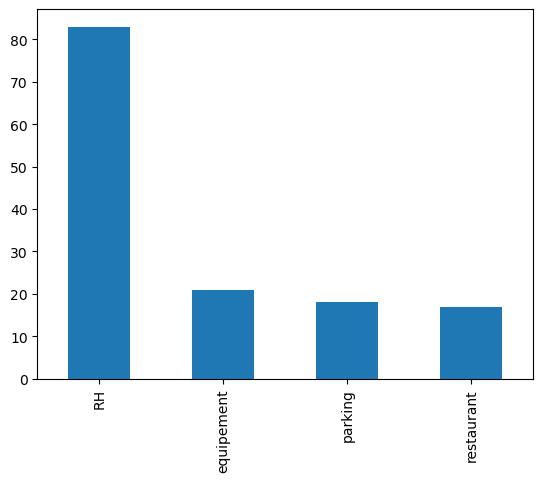

In [291]:
df['label'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [292]:
pip install bert

Note: you may need to restart the kernel to use updated packages.


In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [294]:
one_hot = pd.get_dummies(df["label"])
df.drop(['label'],axis=1,inplace=True)
df = pd.concat([df,one_hot],axis=1)


In [304]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Get the list of stop words
stop_words = set(stopwords.words('english'))

# Function to remove stop words from a text
def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# Apply the remove_stopwords function to the 'complaint' column
df['complaint'] = df['complaint'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DHIBI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [305]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["complaint"].values, df.drop(['complaint'],axis=1).values, test_size=0.02, random_state=42)

In [306]:
y_test

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0]], dtype=uint8)

In [307]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences, maxlen=50)

In [308]:
sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences, maxlen=50)

In [309]:
X_train

array([[  0,   0,   0, ...,  68,  23,  31],
       [  0,   0,   0, ...,  14, 311,   1],
       [  0,   0,   0, ..., 314, 480, 131],
       ...,
       [  0,   0,   0, ...,  81,   7,  52],
       [  0,   0,   0, ...,   1,   8,  24],
       [  0,   0,   0, ..., 251,   5, 167]])

In [310]:
model = Sequential()
model.add(Embedding(20000, 1000, input_length=50))
model.add(Dropout(0.5))  # Increased dropout rate for regularization
model.add(Conv1D(128, 5, activation='relu'))  # Increased number of filters
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128))  # Increased LSTM units
model.add(Dense(4, activation='softmax'))

In [311]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [312]:
model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.3882 - accuracy: 0.1885 - val_loss: 1.2405 - val_accuracy: 0.7857
Epoch 2/10
1/1 [==============================] - 1s 784ms/step - loss: 1.2767 - accuracy: 0.5738 - val_loss: 1.0445 - val_accuracy: 0.7857
Epoch 3/10
1/1 [==============================] - 1s 761ms/step - loss: 1.1570 - accuracy: 0.5738 - val_loss: 0.8272 - val_accuracy: 0.7857
Epoch 4/10
1/1 [==============================] - 1s 778ms/step - loss: 1.0722 - accuracy: 0.5738 - val_loss: 0.7024 - val_accuracy: 0.7857
Epoch 5/10
1/1 [==============================] - 1s 763ms/step - loss: 1.0946 - accuracy: 0.5738 - val_loss: 0.6859 - val_accuracy: 0.7857
Epoch 6/10
1/1 [==============================] - 1s 783ms/step - loss: 1.0459 - accuracy: 0.5738 - val_loss: 0.6923 - val_accuracy: 0.7857
Epoch 7/10
1/1 [==============================] - 1s 772ms/step - loss: 0.9720 - accuracy: 0.5738 - val_loss: 0.7128 - val_accuracy: 0.7857
Epoch 8/10
1/1 [=======

In [313]:
score = model.evaluate(X_test, y_test,
                       batch_size=256, verbose=1)
print('Test accuracy:', score[1])

1/1 [==============================] - 0s 31ms/step - loss: 0.8755 - accuracy: 0.6667
Test accuracy: 0.6666666865348816


In [314]:
preds = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [315]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [316]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(preds,axis=1)))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



In [317]:
preds

array([[0.7195046 , 0.12360743, 0.07434405, 0.08254396],
       [0.67747736, 0.11926875, 0.09771691, 0.10553695],
       [0.6082631 , 0.14838047, 0.12165715, 0.12169935]], dtype=float32)

In [318]:
df.tail()

,complaint,RH,equipement,parking,restaurant
134,company 's performance appraisal system subjec...,1,0,0,0
135,company 's workplace environment noisy distrac...,1,0,0,0
136,Employees experience frequent power outages di...,1,0,0,0
137,company 's furniture seating arrangements unco...,1,0,0,0
138,company 's network security measures insuffici...,1,0,0,0


In [319]:
X_test

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   4, 107,
         33,  57, 692,   1, 439,   5,   3,   5, 188, 150,  26],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   2,   7,  65,  66,  20,  71, 293,  61,   5,  46,  53,
          1,  15, 446,  60, 469,   5, 102,  12,  96,  37, 221],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
        184, 185, 133,  62,   2,   4, 672,  71,  51,  86, 155, 103,  80,
        338,  29,   3, 199,  58,  99, 164,   7, 140,  80,  52]])

In [266]:
score = model.evaluate(X_test, label_encoder.fit_transform(y_test),
                       batch_size=256, verbose=1)
print('Test accuracy:', score[1])

ValueError: y should be a 1d array, got an array of shape (3, 4) instead.

In [267]:
preds = model.predict(X_test)

1/1 [==============================] - 0s 361ms/step


In [268]:
preds

array([[0.7201928 , 0.11953046, 0.08891777, 0.07135895],
       [0.69797057, 0.12285774, 0.10368585, 0.07548583],
       [0.697402  , 0.12582207, 0.09868539, 0.0780905 ]], dtype=float32)

In [269]:
y_test

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0]], dtype=uint8)

In [270]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(preds,axis=1)))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



In [272]:
X_train

array([[  0,   0,   0, ...,  38,  13,  46],
       [  0,   0,   0, ...,  26, 349,   4],
       [  0,   0,   0, ...,  34,   7, 157],
       ...,
       [  0,   0,   0, ..., 103,  18,  69],
       [  0,   0,   0, ..., 358,  19,  39],
       [  0,   0,   0, ...,   9,   1, 194]])

In [273]:
# Preprocess the input data (sequences_matrix) as needed
preprocessed_data = tf.keras.preprocessing.sequence.pad_sequences(sequences_matrix)

# Make predictions
predictions = model.predict(preprocessed_data)


4/4 [==============================] - 1s 66ms/step


In [274]:
predictions

array([[0.60049677, 0.16859823, 0.14633054, 0.08457451],
       [0.5340653 , 0.20768225, 0.1533403 , 0.10491209],
       [0.5297221 , 0.18892412, 0.16351388, 0.1178399 ],
       [0.6545405 , 0.15097223, 0.11928799, 0.07519932],
       [0.5763709 , 0.17383112, 0.15088591, 0.0989121 ],
       [0.50280684, 0.20248258, 0.18057242, 0.11413819],
       [0.55922174, 0.15554978, 0.14754096, 0.13768752],
       [0.49230886, 0.16409348, 0.18000819, 0.16358946],
       [0.4787191 , 0.21109612, 0.18559673, 0.12458798],
       [0.699589  , 0.11941216, 0.10061739, 0.08038139],
       [0.4597186 , 0.19594266, 0.19259508, 0.1517436 ],
       [0.47644392, 0.17886399, 0.19000442, 0.15468767],
       [0.5372901 , 0.1931959 , 0.16454911, 0.10496485],
       [0.60579497, 0.16988212, 0.14341956, 0.0809033 ],
       [0.56164724, 0.166526  , 0.14985351, 0.12197322],
       [0.62988067, 0.15686153, 0.12742087, 0.08583705],
       [0.5678509 , 0.16538732, 0.15062577, 0.11613603],
       [0.516413  , 0.19102457,